# MODELO CENTRALIZADO CON TODOS LOS DATOS

## IMPORTAR LIBRERÍAS

In [2]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import random

## SEMILLA POR REPRODUCIBILIDAD

In [3]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

## PREPROCESO Y DIVISIÓN DE LOS DATOS

In [4]:
folder_path = r"/home/alkain/Escritorio/Github_Repositorios/Microgrid/TrainTestSplit"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_and_preprocess(files):
    df_list = []
    for file in files:
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path, parse_dates=["Time Stamp (local standard time) yyyy-mm-ddThh:mm:ss"])
        df = df.drop(columns='Time Stamp (local standard time) yyyy-mm-ddThh:mm:ss')
        
        df_sampled = df.groupby('source', group_keys=False).apply(lambda x: x.sample(frac=1, random_state=42))
        df_list.append(df_sampled)
    
    full_df = pd.concat(df_list, ignore_index=True)
    
    full_df = pd.get_dummies(full_df, columns=['source'], prefix='src')
    
    return full_df

train_files = [f for f in os.listdir(folder_path) if f.endswith('.csv') and "train" in f]
test_files = [f for f in os.listdir(folder_path) if f.endswith('.csv') and "test" in f]

train_df = load_and_preprocess(train_files)
test_df = load_and_preprocess(test_files)

train_cols = train_df.columns
test_df = test_df.reindex(columns=train_cols).fillna(0)

X_train = train_df.drop(columns=['Pmp (W)']).values.astype(np.float32)
X_test = test_df.drop(columns=['Pmp (W)']).values.astype(np.float32)
y_train = train_df['Pmp (W)'].values.astype(np.float32)
y_test = test_df['Pmp (W)'].values.astype(np.float32)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train).to(device)
y_train_tensor = torch.tensor(y_train).unsqueeze(1).to(device)
X_test_tensor = torch.tensor(X_test).to(device)
y_test_tensor = torch.tensor(y_test).unsqueeze(1).to(device)

/tmp/ipykernel_17204/3916369317.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('source', group_keys=False).apply(lambda x: x.sample(frac=1, random_state=42))
/tmp/ipykernel_17204/3916369317.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('source', group_keys=False).apply(lambda x: x.sample(frac=1, random_state=42))
/tmp/ipykernel_17204/3916369317.py

## DEFINICIÓN DEL MODELO Y SUS CAPAS

In [5]:
class EnhancedDNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Linear(256, 128),
            nn.ReLU(),
            
            nn.Linear(128, 64),
            nn.ReLU(),
            
            nn.Linear(64, 1)
        )
        
    def forward(self, x):
        return self.model(x)

## INICIALIZACIÓN DEL MODELO Y DE LOS HIPERPARÁMETROS

In [6]:
input_dim = X_train.shape[1]
model = EnhancedDNN(input_dim).to(device)

batch_size = 512
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)
criterion = nn.MSELoss()

epochs = 200
best_loss = np.inf
patience = 12
counter = 0
train_losses = []

/home/alkain/miniconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## ENTRENAMIENTO DEL MODELO

In [7]:
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
    
    avg_loss = running_loss / len(train_loader.dataset)
    train_losses.append(avg_loss)
    scheduler.step(avg_loss)
    
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")
    
    if avg_loss < best_loss:
        best_loss = avg_loss
        counter = 0
        torch.save(model.state_dict(), "best_model_all_data.pth")
    else:
        counter += 1
        if counter >= patience:
            print(f"⏹️ Early stopping at epoch {epoch+1}")
            break

model.load_state_dict(torch.load("best_model_all_data.pth"))

Epoch [1/200], Loss: 314.9773
Epoch [2/200], Loss: 43.5830
Epoch [3/200], Loss: 35.3638
Epoch [4/200], Loss: 31.4859
Epoch [5/200], Loss: 28.7057
Epoch [6/200], Loss: 26.5149
Epoch [7/200], Loss: 25.1684
Epoch [8/200], Loss: 24.1872
Epoch [9/200], Loss: 22.9785
Epoch [10/200], Loss: 22.3006
Epoch [11/200], Loss: 21.6910
Epoch [12/200], Loss: 20.8491
Epoch [13/200], Loss: 20.2200
Epoch [14/200], Loss: 19.6242
Epoch [15/200], Loss: 18.7031
Epoch [16/200], Loss: 18.3771
Epoch [17/200], Loss: 17.7695
Epoch [18/200], Loss: 17.3608
Epoch [19/200], Loss: 16.5758
Epoch [20/200], Loss: 16.4603
Epoch [21/200], Loss: 16.1962
Epoch [22/200], Loss: 15.6409
Epoch [23/200], Loss: 15.2277
Epoch [24/200], Loss: 14.9702
Epoch [25/200], Loss: 14.5967
Epoch [26/200], Loss: 14.2417
Epoch [27/200], Loss: 13.9599
Epoch [28/200], Loss: 13.6430
Epoch [29/200], Loss: 13.2953
Epoch [30/200], Loss: 13.2512
Epoch [31/200], Loss: 12.8636
Epoch [32/200], Loss: 12.6650
Epoch [33/200], Loss: 12.5834
Epoch [34/200], Lo

<All keys matched successfully>

## EVALUACIÓN DEL MODELO
Métricas:
* MSE
* MAE
* R^2


📊 Test MSE: 3.6679
📏 Test MAE: 1.0874
📈 Test R2: 0.9974
MAE para Cocoa_CIGS39017.csv: 1.10
MAE para Cocoa_CIGS8-001.csv: 1.71
MAE para Cocoa_CdTe75638.csv: 1.27
MAE para Cocoa_HIT05667.csv: 1.76
MAE para Cocoa_aSiMicro03036.csv: 0.94
MAE para Cocoa_aSiTandem72-46.csv: 0.53
MAE para Cocoa_aSiTriple28324.csv: 1.18
MAE para Cocoa_mSi0166.csv: 0.59
MAE para Cocoa_mSi0188.csv: 0.58
MAE para Cocoa_mSi460A8.csv: 1.76
MAE para Cocoa_xSi12922.csv: 1.93
MAE para Eugene_CIGS39017.csv: 0.97
MAE para Eugene_CIGS8-001.csv: 0.93
MAE para Eugene_CdTe75638.csv: 0.88
MAE para Eugene_HIT05667.csv: 1.38
MAE para Eugene_aSiMicro03036.csv: 0.80
MAE para Eugene_aSiTandem72-46.csv: 0.45
MAE para Eugene_aSiTriple28324.csv: 0.80
MAE para Eugene_mSi0166.csv: 0.47
MAE para Eugene_mSi0188.csv: 0.48
MAE para Eugene_mSi460A8.csv: 1.40
MAE para Eugene_xSi12922.csv: 1.46
MAE para Golden_CIGS1-001.csv: 1.76
MAE para Golden_CIGS39013.csv: 1.58
MAE para Golden_CdTe75669.csv: 1.22
MAE para Golden_HIT05662.csv: 1.76
MAE p

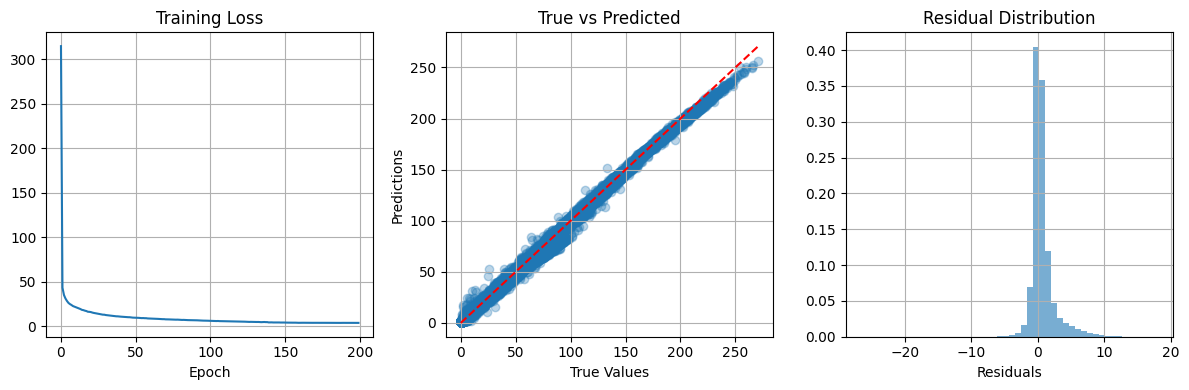

In [8]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).cpu().numpy()
    y_test_np = y_test_tensor.cpu().numpy()
    
    mse = mean_squared_error(y_test_np, y_pred)
    mae = mean_absolute_error(y_test_np, y_pred)
    r2 = r2_score(y_test_np, y_pred)
    
    print(f"\n📊 Test MSE: {mse:.4f}")
    print(f"📏 Test MAE: {mae:.4f}")
    print(f"📈 Test R2: {r2:.4f}")
    
    test_df['pred'] = y_pred
    for col in test_df.filter(regex='^src_').columns:
        if test_df[col].sum() > 0: 
            source_name = col.replace('src_', '')
            subset = test_df[test_df[col] == 1]
            if not subset.empty:
                source_mae = mean_absolute_error(subset['Pmp (W)'], subset['pred'])
                print(f"MAE para {source_name}: {source_mae:.2f}")

plt.figure(figsize=(12, 4))

plt.subplot(131)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.grid(True)

plt.subplot(132)
plt.scatter(y_test_np, y_pred, alpha=0.3)
plt.plot([0, y_test_np.max()], [0, y_test_np.max()], 'r--')
plt.title('True vs Predicted')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)

plt.subplot(133)
residuals = y_test_np - y_pred
plt.hist(residuals, bins=50, density=True, alpha=0.6)
plt.title('Residual Distribution')
plt.xlabel('Residuals')
plt.grid(True)

plt.tight_layout()
plt.show()